<a href="https://colab.research.google.com/github/milipaget/Ejercicio3/blob/master/TP_1_PASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Trabajo Práctico N°1 - Estimación espectral no-paramétrica**
> ### Paget, Milagros 61449
> ### Voss, María de Guadalupe 61583



A lo largo de esta notebook se trabajará sobre la señal gravitatoria GW150914.

In [ ]:
!pip install pydub
!pip install arch

In [ ]:
#Se importan las bibliotecas necesarias.
import numpy as np
import pandas as pd
import scipy as scipy
import matplotlib.pyplot as plt
import scipy.signal.windows as windows
import scipy.signal as signal
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter
import scipy.io.wavfile as wavfile
from pydub import AudioSegment
from numpy.random import uniform
from IPython.display import Audio
from arch.unitroot import unitroot

###Selección del dataset:
Para el desarrollo del código se utilizará el dataset de 4096 segundos y 4kHz. Se optó por esta frecuencia de muestreo dado que la señal a analizar llega a lo sumo a frecuencias de 500Hz.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Se utiliza Google Drive para almacenar el dataset.
#Se importan los datasets necesarios.
H1_dataset = np.loadtxt('/content/drive/My Drive/TP1 PASA/H1_dataset_4K.txt')
L1_dataset = np.loadtxt('/content/drive/My Drive/TP1 PASA/L1_dataset_4K.txt')


In [ ]:
fs = 4096 #Frecuencia de muestreo
seconds = 4096
samples = fs * seconds

### Análisis de datos
A continuación se realizan gráficos de los datasets en función del tiempo para analizar en qué momento ocurre el evento a analizar.

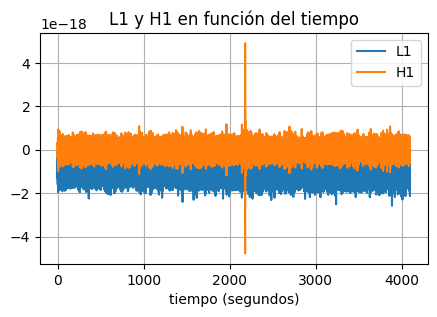

In [ ]:
tiempo = np.linspace(0, seconds, samples)
plt.figure(figsize=(5, 3))
plt.plot(tiempo, L1_dataset, label='L1')
plt.plot(tiempo, H1_dataset, label='H1')
plt.xlabel('tiempo (segundos)')
plt.title('L1 y H1 en función del tiempo')
plt.legend()
plt.grid()
plt.show()

### Validación de la estacionariedad de la señal

En esta sección, se verifica la estacionariedad de las señales L1 y H1 en una ventana de tiempo específica alrededor de un evento. Esto se logra mediante el uso de la prueba ADF (Augmented Dickey-Fuller) y la prueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin).

Primero, se define la ventana de tiempo cercana al evento y se convierten los tiempos en índices para recortar las señales. Además, se ajustan los datos de las señales para facilitar el análisis.

A continuación, se ejecutan las pruebas ADF y KPSS en ambas señales, L1 y H1, dentro de la ventana de tiempo. Las pruebas calculan una estadística de prueba que se compara con un valor crítico al 1% de confianza. Si la estadística de prueba es más negativa que el valor crítico, se concluye que la señal es estacionaria al 1% de confianza; de lo contrario, se considera no estacionaria.


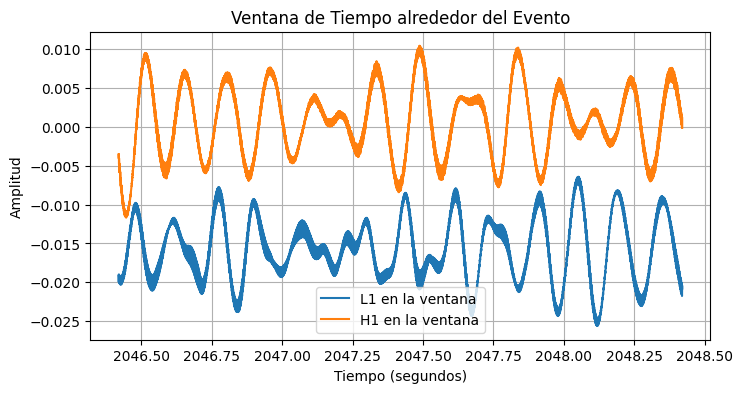

In [ ]:
# Defino la ventana de tiempo
event_time = 2047.42
window_width = 2  # Ancho de la ventana en segundos
start_time = event_time - (window_width / 2)
end_time = event_time + (window_width / 2)

# Convertir el tiempo a índices
start_index = int(start_time * fs)
end_index = int(end_time * fs)

# Ajusto los datos, ya que los valores son muy bajos.
signal_l = L1_dataset[start_index:end_index] * 1e20 / np.abs(np.argmax(L1_dataset[start_index:end_index] * 1e20))
signal_h = H1_dataset[start_index:end_index] * 1e20 / np.abs(np.argmax(H1_dataset[start_index:end_index] * 1e20))

# Ventana de tiempo
L1_window = signal_l
H1_window = signal_h

# Visualizar la ventana de tiempo
plt.figure(figsize=(8, 4))
plt.plot(tiempo[start_index:end_index], L1_window, label='L1 en la ventana')
plt.plot(tiempo[start_index:end_index], H1_window, label='H1 en la ventana')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.title('Ventana de Tiempo alrededor del Evento')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Ajusto los datos, ya que los valores son muy bajos.
L1_noise = L1_dataset[1900*fs:start_index] * 1e20 / np.abs(np.argmax(L1_dataset[1900*fs:start_index] * 1e20))
H1_noise = H1_dataset[1900*fs:start_index] * 1e20 / np.abs(np.argmax(H1_dataset[1900*fs:start_index] * 1e20))

# Realizo la prueba de raíz unitaria ADF con arch.unitroot en la ventana de tiempo en L1 y H1
adf_L1 = unitroot.ADF(L1_noise)
adf_H1 = unitroot.ADF(H1_noise)
# Realizo la prueba KPSS en la ventana de tiempo en L1 y H1
kpss_L1 = unitroot.KPSS(L1_noise)
kpss_H1 = unitroot.KPSS(H1_noise)

# Teniendo adf_H1 y adf_L1 ahora puedo verificar si la señal es estacionaria o no

print("Prueba ADF: resultados para L1 en la ventana de tiempo:")
print("Estadística de prueba ADF:", adf_L1.stat)
print("Valor crítico al 1%:", adf_L1.critical_values['1%'])

# Compara la estadística de prueba con el valor crítico al 1%
if adf_L1.stat < adf_L1.critical_values['1%']:
    print("Con la prueba ADF la señal L1 en la ventana de tiempo es estacionaria al 1% de confianza.")
else:
    print("Con la prueba ADF la señal L1 en la ventana de tiempo no es estacionaria al 1% de confianza.")

print("Prueba KPSS: resultados para L1 en la ventana de tiempo:")
print("Estadística de prueba KPSS:", kpss_L1.stat)
print("Valor crítico al 1%:", kpss_L1.critical_values['1%'])

# Compara la estadística de prueba con los valores críticos
if kpss_L1.stat < kpss_L1.critical_values['1%']:
    print("Con la prueba KPSS la señal L1 en la ventana de tiempo es estacionaria al 1% de confianza.")
else:
    print("Con la prueba KPSS la señal L1 en la ventana de tiempo no es estacionaria al 1% de confianza.")


print("")

print("Prueba ADF: resultados para H1 en la ventana de tiempo:")
print("Estadística de prueba ADF:", adf_H1.stat)
print("Valor crítico al 1%:", adf_H1.critical_values['1%'])

# Compara la estadística de prueba con el valor crítico al 1%
if adf_H1.stat < adf_H1.critical_values['1%']:
    print("Con la prueba ADF la señal H1 en la ventana de tiempo es estacionaria al 1% de confianza.")
else:
    print("Con la prueba ADF la señal H1 en la ventana de tiempo no es estacionaria al 1% de confianza.")

print("Prueba KPSS: resultados para H1 en la ventana de tiempo:")
print("Estadística de prueba KPSS:", kpss_H1.stat)
print("Valor crítico al 1%:", kpss_H1.critical_values['1%'])

# Compara la estadística de prueba con los valores críticos
if kpss_H1.stat < kpss_H1.critical_values['1%']:
    print("Con la prueba KPSS la señal H1 en la ventana de tiempo es estacionaria al 1% de confianza.")
else:
    print("Con la prueba KPSS la señal H1 en la ventana de tiempo no es estacionaria al 1% de confianza.")



Prueba ADF: resultados para L1 en la ventana de tiempo:
Estadística de prueba ADF: -79.59111211630174
Valor crítico al 1%: -3.4303609056233006
Con la prueba ADF la señal L1 en la ventana de tiempo es estacionaria al 1% de confianza.
Prueba KPSS: resultados para L1 en la ventana de tiempo:
Estadística de prueba KPSS: 0.014392429425896075
Valor crítico al 1%: 0.7428
Con la prueba KPSS la señal L1 en la ventana de tiempo es estacionaria al 1% de confianza.

Prueba ADF: resultados para H1 en la ventana de tiempo:
Estadística de prueba ADF: -60.60572517570516
Valor crítico al 1%: -3.4303609056233006
Con la prueba ADF la señal H1 en la ventana de tiempo es estacionaria al 1% de confianza.
Prueba KPSS: resultados para H1 en la ventana de tiempo:
Estadística de prueba KPSS: 0.00656431484333602
Valor crítico al 1%: 0.7428
Con la prueba KPSS la señal H1 en la ventana de tiempo es estacionaria al 1% de confianza.


En conclusión, este análisis determina que el ruido de las señales L1 y H1 es estacionario con un nivel de confianza del 1%, ya que esto dio afirmativo para las dos pruebas realizadas.

### **1. Estimación del espectro de potencia de ruido de H1 y L1.**

### a. Periodograma
Al momento de elegir el tamaño (N) de la ventana a utilizar se pueden analizar diferentes factores.

> Cantidad de datos: Mientras mayor sea la cantidad de datos disponibles para el cálculo del periodograma, mayor será el tamaño posible. Sin embargo, se deben tener en cuenta otros factores debido a que no siempre mayor tamaño implica mejores resultados.

>Resolución en frecuencia: Este factor resulta de mayor importancia cuando la señal a analizar contiene componentes de alta frecuencia. Corresponde con la diferencia entre las frecuencias distinguibles en el periodograma.

>Costo computacional: Siempre es importante considerar los recursos con los que uno trabaja. Si bien es posible utilizar tantos datos como se quiera, esto puede acarrear un costo computacional o de memoria muy grande. Por ende se deben tener en cuenta los recursos disponibles y actuar en consecuencia.

Se puede ver como todos los factores estan estrechamente relacionados. Es por esta razón que se debe considerarlos en su totalidad aunque estableciendo prioridades.


In [ ]:
def periodogram_calc(dataset, N):
  fs = 4096
  w_signal = dataset[:N] * windows.parzen(N)
  w_signal_fft = scipy.fft.fft(w_signal)
  frequencies = scipy.fft.fftfreq(len(w_signal), 1/fs)
  periodogram = np.abs(w_signal_fft)**2/N
  return frequencies, np.abs(periodogram)

In [ ]:
def graph_periodograms(dataset_1, dataset_2):
  fig2,axs = plt.subplots(5,3,figsize=(10,15))
  N = 1024
  for ax in axs.flatten():
    frequencies_1, periodogram_1 = periodogram_calc(dataset_1, N)
    frequencies_2, periodogram_2 = periodogram_calc(dataset_2, N)
    end_idx_1 = int(len(frequencies_1)/2)
    end_idx_2 = int(len(frequencies_2)/2)
    ax.plot(frequencies_1[:end_idx_1], 10*np.log10(periodogram_1)[:end_idx_1], label='Periodograma H1', color='indigo')
    ax.plot(frequencies_2[:end_idx_1], 10*np.log10(periodogram_2)[:end_idx_1], label='Periodograma L1', color='limegreen')
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel('Densidad de Potencia Espectral[dB]')
    ax.set_title('Periodograma N = ' + str(N))
    ax.legend()
    N = N + 1024
    ax.set_xscale('log')

  plt.tight_layout()
  plt.show()

A continuación se realiza un análisis del mejor tamaño de ventana para el dataset que se tiene. Al ser un ruido estacionario se puede utilizar uno de los dos extremos desde el evento. Se utilizará el extremo izquierdo, arbitrariamente.

In [ ]:
H1_dataset_new = H1_dataset[:start_index] - np.mean(H1_dataset[:start_index])
L1_dataset_new = L1_dataset[:start_index] - np.mean(L1_dataset[:start_index])

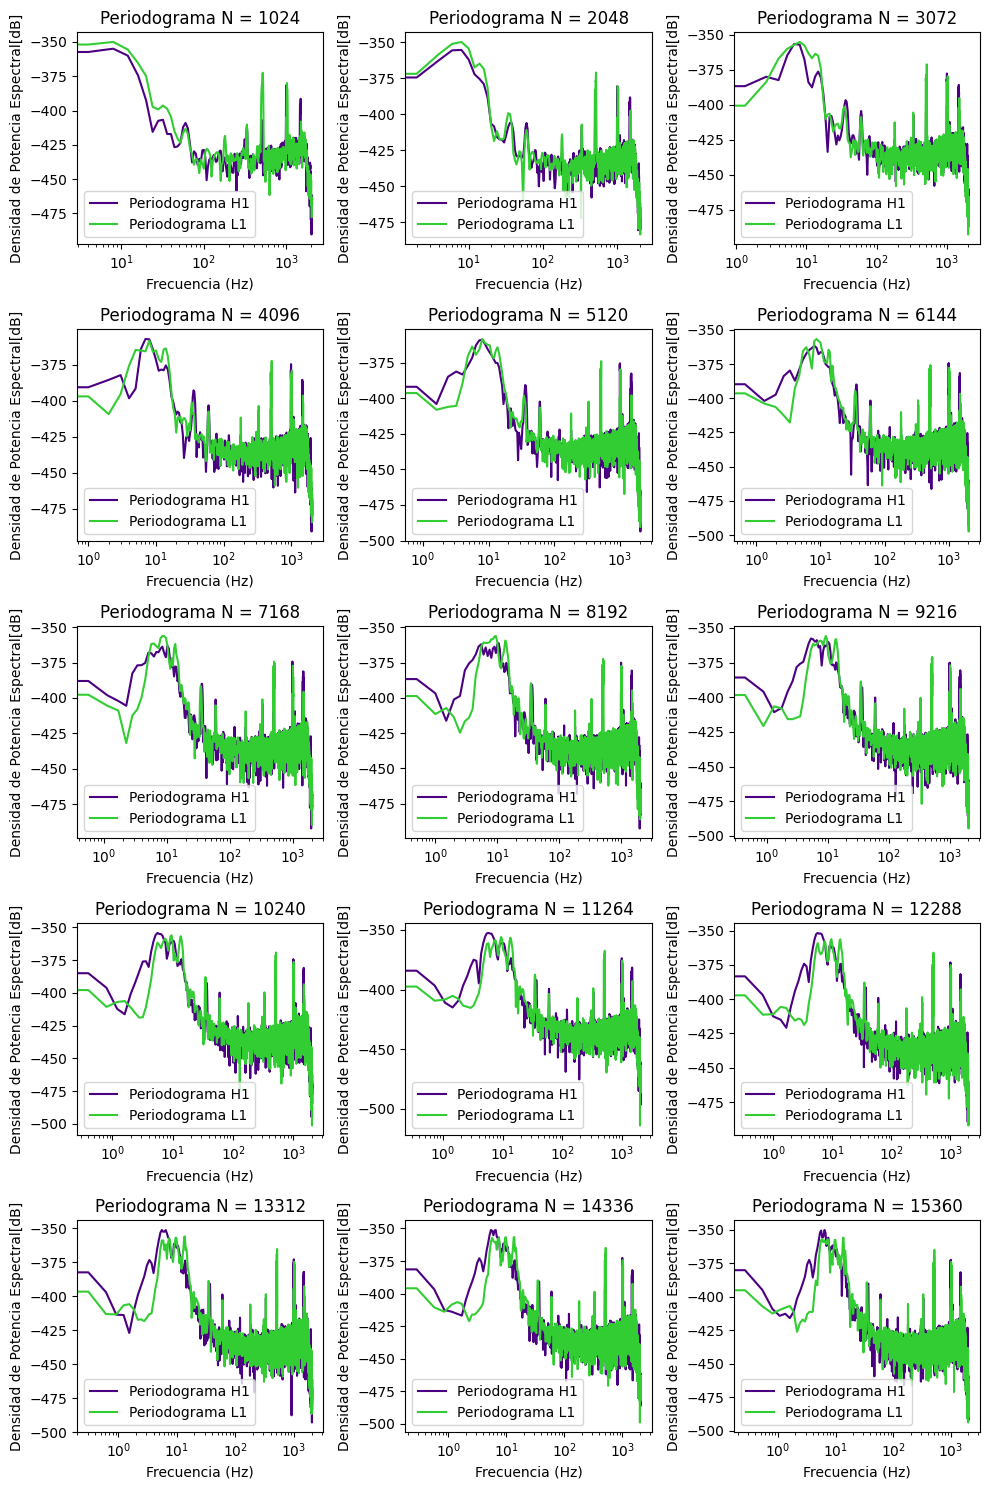

In [ ]:
graph_periodograms(H1_dataset_new, L1_dataset_new)


Considerando la relación resolución en frecuencia - costo computacional, se opta por utilizar N = 8196. Se optó por este valor dado que mirando las imágenes anteriores es el que presenta mejor relación resolución-varianza.

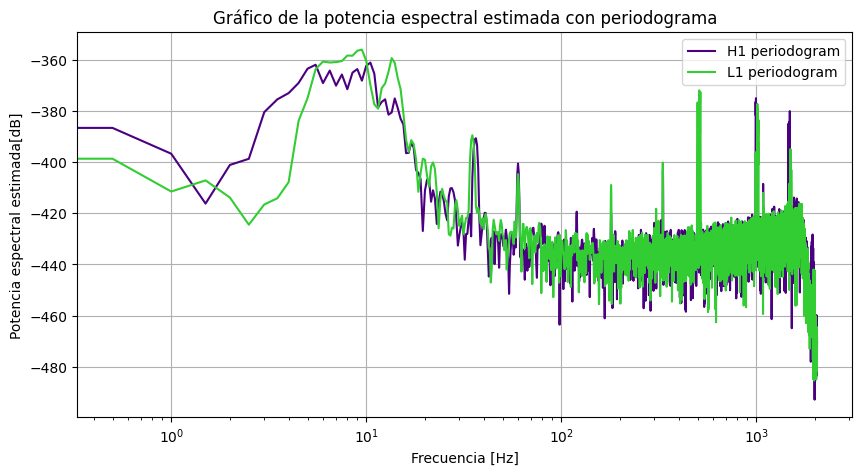

In [ ]:
#Periodograma para N elegido
N = 8196
frequencies_h, periodogram_h = periodogram_calc(H1_dataset_new, N)
frequencies_l, periodogram_l = periodogram_calc(L1_dataset_new, N)
end_idx = int(len(frequencies_h)/2)
plt.figure(figsize=(10, 5))
plt.plot(frequencies_h[0:end_idx], 10*np.log10(periodogram_h)[0:end_idx], label='H1 periodogram', color='indigo')
plt.plot(frequencies_l[0:end_idx:], 10*np.log10(periodogram_l)[0:end_idx], label='L1 periodogram', color='limegreen')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia espectral estimada[dB]')
plt.title('Gráfico de la potencia espectral estimada con periodograma')
plt.legend()
plt.xscale('log')
plt.grid()
plt.show()

### b. Periodogram smoothing
En la estimación de la potencia espectral mediante el suavizado de periodograma se promedian valores contiguos de un periodograma.
Se utilizará N = 8196 a lo largo del cálculo del periodograma suavizado. Se varía L en un rango de valores dados por múltiplos de N, dando un valor de L menor que N.

In [ ]:
def periodogram_smoothing(dataset, N, L):
  fs = 4096
  w_signal = windows.parzen(2*L-1)
  dataset_signal = dataset[:N]*windows.parzen(N)
  correlated_signal = signal.correlate(dataset_signal, dataset_signal, mode='full')
  pad_ancho = int((len(correlated_signal)-len(w_signal))/2)
  pad = np.pad(array = w_signal, pad_width = pad_ancho)
  periodogram_smoothing = np.fft.fft(correlated_signal * pad)
  frequencies = np.fft.fftfreq(len(periodogram_smoothing), 1/fs)
  return frequencies, np.abs(periodogram_smoothing)


In [ ]:
def graph_smooth_periodograms(dataset_1, dataset_2, N):
  L = [[int(N/4), int(N/5)], [int(N/6), int(N/7)], [int(N/8), int(N/9)]]
  fig2,axs = plt.subplots(3,2,figsize=(10,15))
  for i in range(3):
    for j in range(2):
      frequencies_1, periodogram_1 = periodogram_smoothing(dataset_1, N, L[i][j])
      frequencies_2, periodogram_2 = periodogram_smoothing(dataset_2, N, L[i][j])
      end_idx_1 = int(len(frequencies_1) / 2)
      end_idx_2 = int(len(frequencies_2) / 2)
      axs[i, j].plot(frequencies_1[:end_idx_1], 10 * np.log10(periodogram_1)[:end_idx_1], label='Periodograma H1', color='indigo')
      axs[i, j].plot(frequencies_2[:end_idx_1], 10 * np.log10(periodogram_2)[:end_idx_1], label='Periodograma L1', color='limegreen')
      axs[i, j].set_xlabel('Frecuencia (Hz)')
      axs[i, j].set_ylabel('Densidad de Potencia Espectral[dB]')
      axs[i, j].set_title('Periodograma N = ' + str(N) + ' L = ' + str(L[i][j]))
      axs[i, j].legend()
      axs[i, j].set_xscale('log')

  plt.tight_layout()
  plt.show()

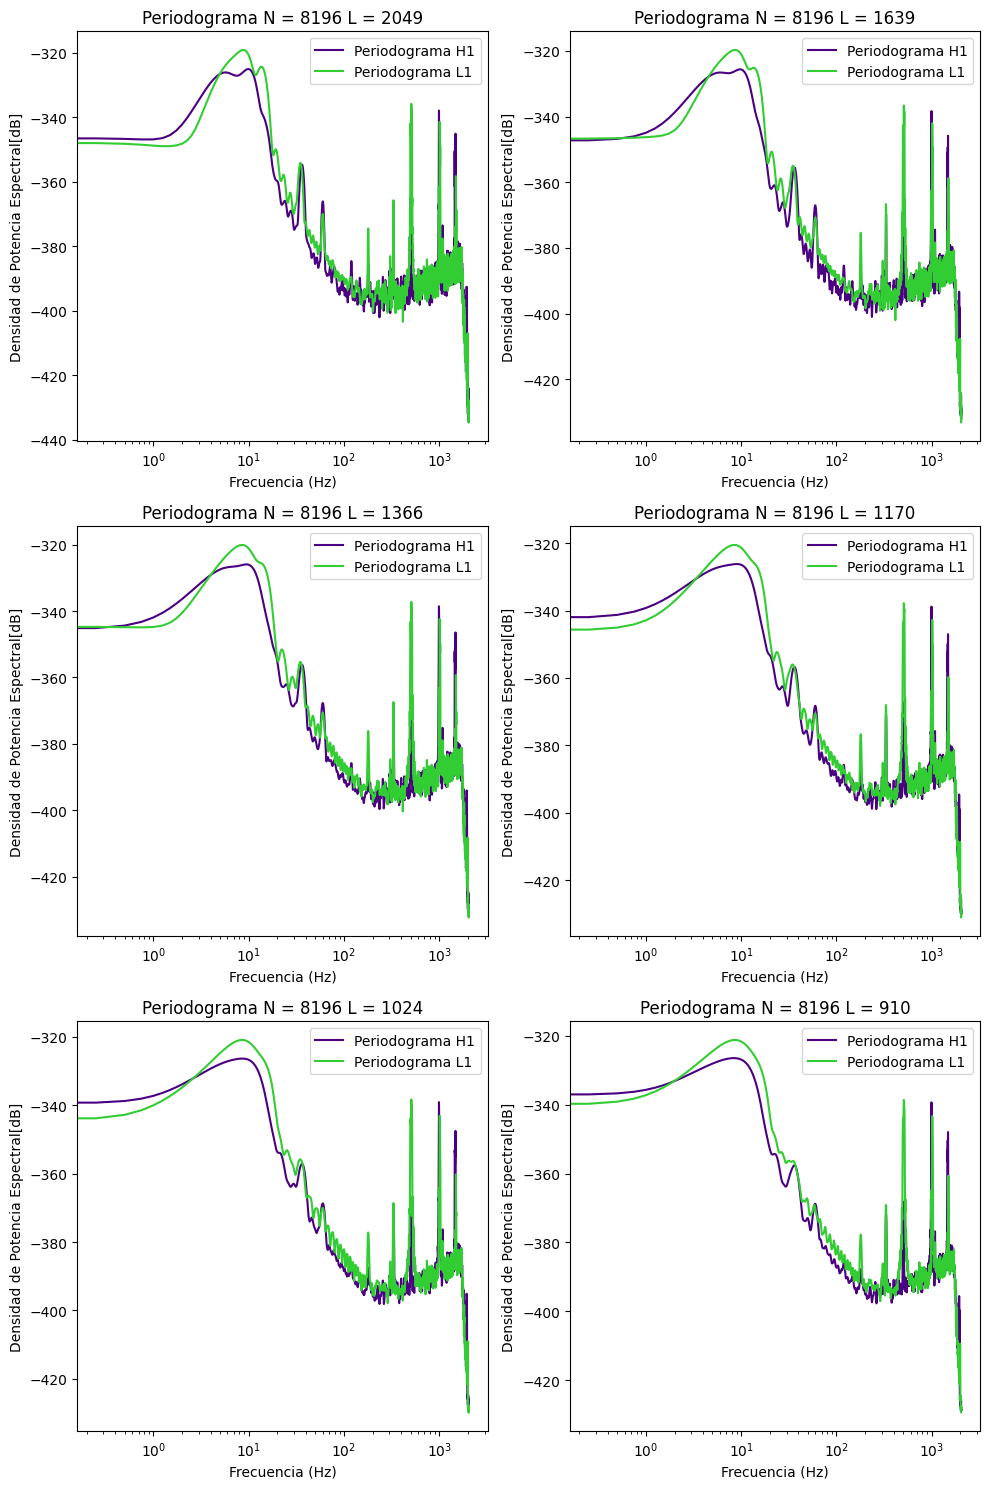

In [ ]:
graph_smooth_periodograms(H1_dataset_new, L1_dataset_new, N)

### c. Periodogram averaging

Para estimar la potencia espectral mediante el promediado de periodogramas, lo que se hace es, como bien establece el nombre, promediar periodogramas.

Con el objetivo de realizar este promedio se divide el dataset en diferentes intervalos de información y se establece un parámetro de superposición, el cual establecerá cuantos puntos de datos se superponen entre segmentos contiguos.
Este parámetro es de suma importancia ya que afecta en gran medida a la calidad de la estimación.

Existen 3 casos extremos de superposición:
> 1. **Sin superposición (overlap = 0)**. Cada intervalo es independiente del resto. Este caso puede ser útil para una señal estacionaria en la que se desea una estimación rápida. La desventaja es que puede presentar mayor ruido.

> 2. **Superposición del 50% (overlap = N/2)**. En este caso, la mitad de los puntos se superpondrán con la mitad de los puntos del intervalo siguiente. De esta manera se logra una disminución del ruido sin descuidar demasiado el tiempo de cómputo.

>3. **Superposición completa (overlap = N - 1)**. Aquí todos los puntos se superponen con los puntos del intervalo siguiente. Si bien el ruido es prácticamente nulo, el costo computacional hace que esta opción no sea viable en la mayoría de los casos.

Por lo general, un overlap mayor al 50% no genera un cambio significativo en la varianza.

In [ ]:
def periodogram_averaging(dataset, N, L, overlap):
  D_size = L - overlap
  K_segments = int(N // D_size) + 1
  periodograms = np.zeros(L)
  for i in range(K_segments):
    start_idx = int(i*D_size)
    end_idx = start_idx + L
    signal_segment = dataset[start_idx:end_idx]
    frequencies, periodogram = periodogram_calc(signal_segment, L)
    periodograms += np.abs(periodogram)

  averaged_periodogram = periodograms/ (K_segments)

  return frequencies, averaged_periodogram

In [ ]:
def graph_average_periodograms(dataset_1, dataset_2, N):
  fig2,axs = plt.subplots(1,3,figsize=(15,5))
  L = int(N/8)
  overlaps = [0, int(L/2), int(3*L/4)]#, N-1]
  for i, ax in enumerate(axs.flatten()):
    frequencies_1, periodogram_1 = periodogram_averaging(dataset_1, N, L, overlaps[i])
    frequencies_2, periodogram_2 = periodogram_averaging(dataset_2, N, L, overlaps[i])
    end_idx_1 = int(len(frequencies_1)/2)
    end_idx_2 = int(len(frequencies_2)/2)
    ax.plot(frequencies_1[:end_idx_1], 10*np.log10(periodogram_1)[:end_idx_1], label='Periodograma H1', color='indigo')
    ax.plot(frequencies_2[:end_idx_1], 10*np.log10(periodogram_2)[:end_idx_1], label='Periodograma L1', color='limegreen')
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel('Densidad de Potencia Espectral[dB]')
    if(i==0):
      title = 'Sin superposición'
    elif(i==1):
      title = 'Superposición del 50%'
    elif(i==2):
      title = 'Superposición del 75%'
    ax.set_title(title)
    ax.legend()
    ax.set_xscale('log')

  plt.tight_layout()
  plt.show()

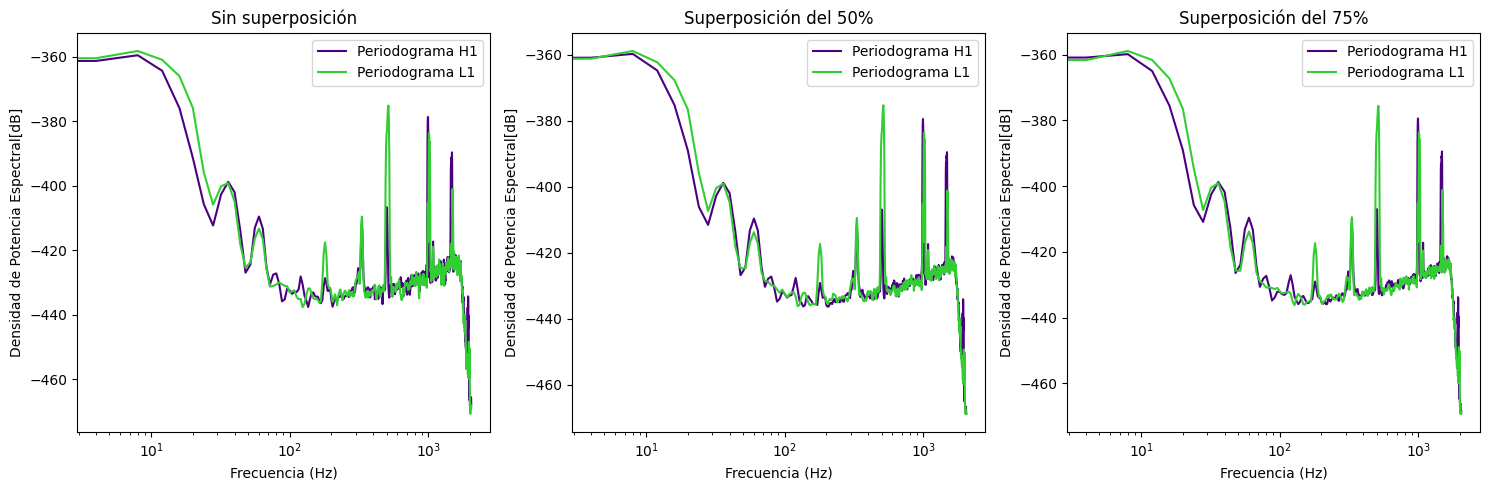

In [ ]:
graph_average_periodograms(H1_dataset_new, L1_dataset_new, N)

### ¿Cuál produce las mejores estimaciones?



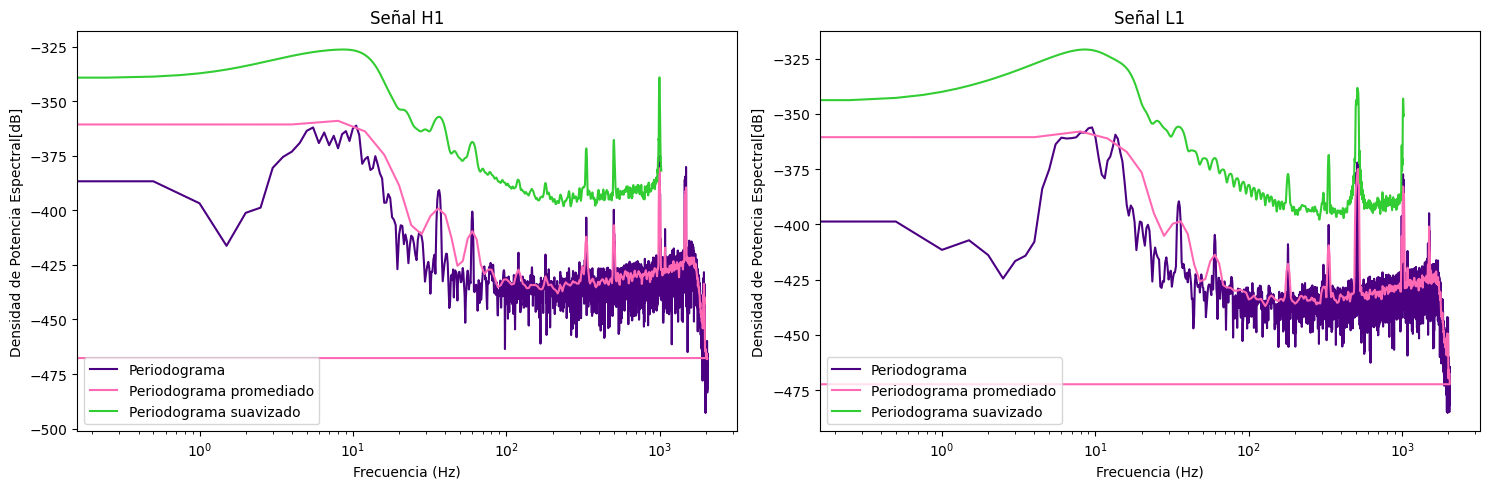

In [ ]:
N = 8196
L = int(N/8)
overlap = int(L/4)

frequencies_h, periodogram_h = periodogram_calc(H1_dataset_new, N)
frequencies_l, periodogram_l = periodogram_calc(L1_dataset_new, N)
frequencies_h_av, periodogram_h_av = periodogram_averaging(H1_dataset_new, N, L, overlap)
frequencies_l_av, periodogram_l_av = periodogram_averaging(L1_dataset_new, N, L, overlap)
frequencies_h_sm, periodogram_h_sm = periodogram_smoothing(H1_dataset_new, N, L)
frequencies_l_sm, periodogram_l_sm = periodogram_smoothing(L1_dataset_new, N, L)
end_idx = int(len(frequencies_h)/2)
sig = ['H1', 'L1']
per=[periodogram_h, periodogram_l, periodogram_h_av, periodogram_l_av, periodogram_h_sm, periodogram_l_sm]

fig1, axs = plt.subplots(1,2,figsize=(15,5))
for i, ax in enumerate(axs.flatten()):
  ax.plot(frequencies_h[:end_idx], 10*np.log10(per[i])[:end_idx], label='Periodograma', color='indigo')
  ax.plot(frequencies_h_av[:end_idx], 10*np.log10(per[i+2])[:end_idx], label='Periodograma promediado', color='hotpink')
  ax.plot(frequencies_h_sm[:end_idx], 10*np.log10(per[i+4])[:end_idx], label='Periodograma suavizado', color='limegreen')
  ax.set_xlabel('Frecuencia (Hz)')
  ax.set_ylabel('Densidad de Potencia Espectral[dB]')
  ax.set_title('Señal '+ sig[i])
  ax.legend()
  ax.set_xscale('log')

plt.tight_layout()
plt.show()

Se puede apreciar en la imágen anterior que la mejor estimación se realiza con el periodograma suavizado ya que es la que posee menor varianza, manteniendo una buena resolución.

### Comparación entre estimaciones de H1  y L1

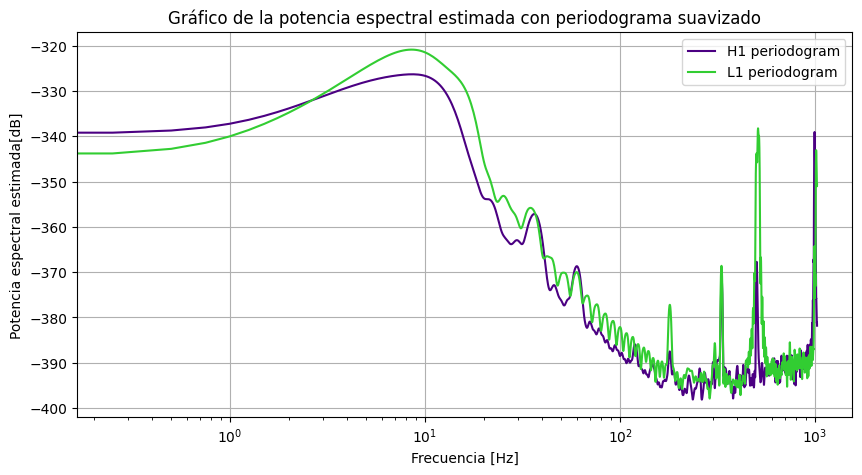

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(frequencies_h_sm[0:end_idx], 10*np.log10(periodogram_h_sm)[0:end_idx], label='H1 periodogram', color='indigo')
plt.plot(frequencies_l_sm[0:end_idx:], 10*np.log10(periodogram_l_sm)[0:end_idx], label='L1 periodogram', color='limegreen')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia espectral estimada[dB]')
plt.title('Gráfico de la potencia espectral estimada con periodograma suavizado')
plt.legend()
plt.xscale('log')
plt.grid()
plt.show()

Se puede notar como los picos en la señal L1 resultan con una potencia mayor que la H1. Por otro lado, se considera que la señal H1 posee mayor resolución.

A pesar de esto, las estimaciones resultan muy similares.

### **2. Whitening de la señal gravitatoria.**
El objetivo de realizar el whitening es eliminar la correlación entre muestras de la señal y por lo tanto intentar disminuir el ruido.

In [ ]:
N = 8192
L = int(N/4)
overlap = int(L/4)

frequencies_L, periodogram_L_av = periodogram_smoothing(L1_dataset_new, N, L)
frequencies_H, periodogram_H_av = periodogram_smoothing(H1_dataset_new, N, L)

frequencies_L = np.linspace(0,0.5, len(periodogram_L_av)) * fs
frequencies_H = np.linspace(0,0.5, len(periodogram_H_av)) * fs

In [ ]:
power_h = interp1d(frequencies_H, periodogram_H_av, kind='nearest', bounds_error=False, assume_sorted=True)
power_l = interp1d(frequencies_L, periodogram_L_av, kind='nearest', bounds_error=False, assume_sorted=True)

In [ ]:
power_h1 = np.abs(power_h(np.fft.rfftfreq(len(H1_dataset), 1/fs)))**2
power_l1 = np.abs(power_l(np.fft.rfftfreq(len(L1_dataset), 1/fs)))**2

In [ ]:
whitened_signal_h = np.fft.irfft(np.fft.rfft(H1_dataset) / np.sqrt(power_h1))
whitened_signal_l = np.fft.irfft(np.fft.rfft(L1_dataset) / np.sqrt(power_l1))

In [ ]:
#Filtro Butter Pasa Banda
nyquist_frequency = 0.5 * fs
low_h = 50
high_h = 250
low_h2 = low_h / nyquist_frequency
high_h2 = high_h / nyquist_frequency
bh, ah = butter(6, [low_h2, high_h2], btype='band')

low_l = 50
high_l = 250
low_l2 = low_l / nyquist_frequency
high_l2 = high_l / nyquist_frequency
bl, al = butter(6, [low_l2, high_l2], btype='band')

# Apply passband filter
whitened_filtered_signal_h = lfilter(bh, ah, whitened_signal_h)
whitened_filtered_signal_l = lfilter(bl, al, whitened_signal_l)

In [ ]:
#Archivo WAV para poder escuchar el evento
gw_dataset_H1 = np.int16(whitened_filtered_signal_h[start_index:end_index+fs]/np.max(np.abs(whitened_filtered_signal_h[start_index:end_index+fs])) * 32767 * 0.9)
gw_dataset_L1 = np.int16(whitened_filtered_signal_l[start_index:end_index+fs]/np.max(np.abs(whitened_filtered_signal_l[start_index:end_index+fs])) * 32767 * 0.9)
wavfile.write('h1_gw.wav', int(fs), gw_dataset_H1)
wavfile.write('l1_gw.wav', int(fs), gw_dataset_L1)

In [89]:
display(Audio('h1_gw.wav'))

In [90]:
display(Audio('l1_gw.wav'))

### **3. Estimación de la correlación cruzada y el ángulo de cono de arribo de la señal.**

In [ ]:
event_time= 2047.422
delta = 0.2
start_idx = int(fs*(event_time - delta))
end_idx = int(fs*(event_time + delta))
L_H_cross_correlation = signal.correlate(whitened_filtered_signal_h[start_idx:end_idx],-whitened_filtered_signal_l[start_idx:end_idx], 'full')
deltaT = (np.argmax(L_H_cross_correlation)-len(whitened_filtered_signal_h[start_idx:end_idx]))/fs * 1e3
print(deltaT, 'ms')

7.080078125 ms


Para estimar el ángulo de arribo de la señal se tuvieron las siguientes consideraciones: considerando que las señales que llegan a la tierra son paralelas (dado que la distancia a la que ocurre el evento es muy alta) y teniendo en cuenta que las señales L1 y H1 fueron tomadas a una distancia de 3002km entre sí se puede realizar el siguiente esquema:

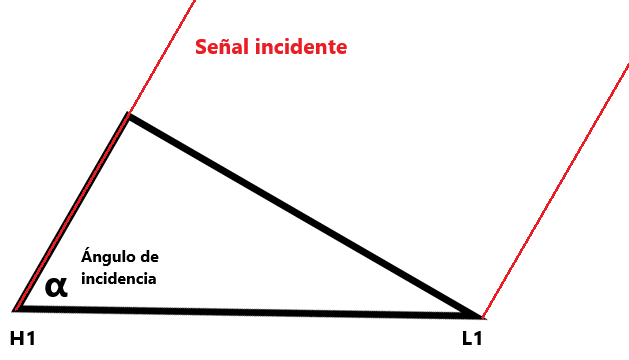

Además considerando que las ondas gravitatorias se propagan a la velocidad de la luz y a partir del tiempo de retaedo calculado antariormente, se puede calcular el ángulo de arribo a partir de:

**cos(α) = D/(t.c)**



*   D: Distancia entre interferometros.
*   t: Tiempo de retardo entre señales
*   c: Velocidad de la luz



In [ ]:
temp = deltaT/1000
c = 3*(10**8)
D = 3002*(10**3)

alfa = np.arccos((temp*c)/D)* (180/np.pi)

print(alfa,'°')

44.96520062144332 °
